# Создание визуализации определения средневзвешенного по суммарной энергии кластеров 

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 

In [3]:
import pandas as pd

def read_binarry(file_path):
    import struct
    import math

    energy = []
    coordinate_x = []
    coordinate_y = []

    with open(file_path, 'rb') as binary_file:
        for i in range(100000):
            binary_file.read(4 * 5)

            tetta = struct.unpack('f', binary_file.read(4))[0]
            

            phi = struct.unpack('f', binary_file.read(4))[0]
            

            x0 = struct.unpack('f', binary_file.read(4))[0]
            coordinate_x.append(x0)
            

            y0 = struct.unpack('f', binary_file.read(4))[0]
            coordinate_y.append(y0)
            

            binary_file.read(4 * 5)

            power_eas = struct.unpack('f', binary_file.read(4))[0]
            

            age_eas = struct.unpack('f', binary_file.read(4))[0]
            

            binary_file.read(4 * 1565)
            energy_release = struct.unpack('f' * 36, binary_file.read(4 * 36))
            energy.append(energy_release)

            binary_file.read(4)
            t = struct.unpack('f' * 144, binary_file.read(4 * 144))
            threshold_time = t[::4]
            

    # Собираем всё в DataFrame
    df = pd.DataFrame({
        'energy': energy,
        'x': coordinate_x,
        'y': coordinate_y
    })

    return df


In [4]:
data = read_binarry('spe27p_100k_2022_correct.dat')

___
## Локальные координаты центра каждого кластера (приблизительные)

In [5]:
cluster_centers = np.array([
    [-30.0, 0.0],
    [-30.0, 30.0],
    [0.0, 0.0],
    [30, 5],
    [30, 38],
    [3, -65],
    [-15, 50],
    [35, -25],
    [-30, -30]])

___

## Сумма энергии по каждому кластеру

In [6]:
def sum_energy_by_cluster(energy_tuple):
    energies = np.array(energy_tuple)
    
    if len(energies) != 36:
        raise ValueError(f"Ожидается 36 значений, получено {len(energies)}")
    
    cluster_energies = energies.reshape(9, 4)
    
    cluster_sums = np.sum(cluster_energies, axis=1)
    
    return cluster_sums

___

## Визуализация

Схема центра НЕВОД

Чем больше радиус круга - тем больше энергии было определено

- Фиолетовая звезда - угаданные координаты
- Зеленая звезда - настоящие координаты
- Красная стрелка - показывает в сторону севера

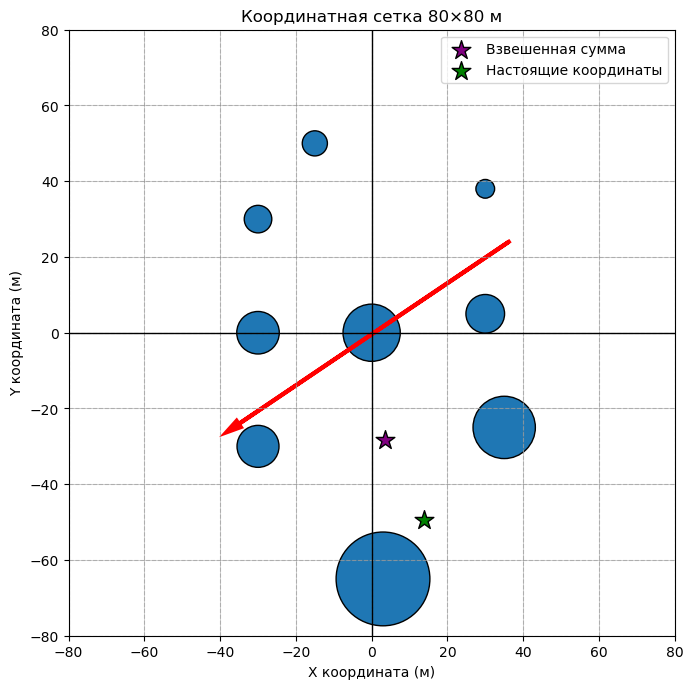

In [7]:
idx = 20

sizes = [x*10 for x in sum_energy_by_cluster(data.iloc[idx].tolist()[0]).tolist()]
real_x = data.iloc[idx].tolist()[1]
real_y = data.iloc[idx].tolist()[2]


fig, ax = plt.subplots(figsize=(7, 7))

ax.set_xlim(-80, 80)
ax.set_ylim(-80, 80)

for x in np.arange(-80, 81, 20):
    ax.axvline(x, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
for y in np.arange(-80, 81, 20):
    ax.axhline(y, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

ax.set_xlabel('X координата (м)')
ax.set_ylabel('Y координата (м)')
ax.set_title('Координатная сетка 80×80 м')

ax.set_xticks(np.arange(-80, 81, 20))
ax.set_yticks(np.arange(-80, 81, 20))

ax.set_aspect('equal')

ax.scatter([x[0] for x in cluster_centers], [x[1] for x in cluster_centers], s=sizes, edgecolors='black')


# Вычисление взвешенной суммы
weighted_sum_x = np.sum(cluster_centers[:, 0] * sizes)
weighted_sum_y = np.sum(cluster_centers[:, 1] * sizes)
total_weight = np.sum(sizes)

# Координаты результирующей точки
result_x = weighted_sum_x / total_weight
result_y = weighted_sum_y / total_weight

angle_deg = 214
angle_rad = np.deg2rad(angle_deg)
length = 90  # Длина стрелки

end_x = length * np.cos(angle_rad)
end_y = length * np.sin(angle_rad)

plt.arrow(36.2, 24, end_x, end_y, 
          head_width=2.0, head_length=4.0, 
          fc='red', ec='red', linewidth=3,
          length_includes_head=True)

plt.scatter(result_x, result_y, c='purple', s=200, marker='*', label='Взвешенная сумма', edgecolors='black')
plt.scatter(real_x, real_y, c='green', s=200, marker='*', label='Настоящие координаты', edgecolors='black')

plt.legend()

plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()